In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy import NaN
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import preprocessing

from sklearn import impute


In [2]:
def load_data(x_path):
    return pd.read_csv(x_path, low_memory=False)

In [3]:
x = load_data("train_x.csv")
y = load_data("train_y.csv")
mapping = dict(zip(y['patientunitstayid'], y['hospitaldischargestatus']))
x['hospitaldischargestatus'] = x['patientunitstayid'].map(mapping)

def extract_values(data, threshold, valName):
    if(data.empty):
        return 0,0,0,0
    
    data[valName] = data[valName].astype(float) 
    data = data[data[valName] < threshold] #remove outliers
    data = data.sort_values('offset')     #sort by offset to get first and last values recorded
    
    maxHeartData = data[valName].max()
    minHeartData = data[valName].min()
    
    if data.empty:
        return maxHeartData, minHeartData, 0, 0
    firstHeartData = data[valName].iloc[0]
    lastHeartData = data[valName].iloc[-1]
    
    return maxHeartData, minHeartData, firstHeartData, lastHeartData

def add_columns(df, name, data):
    df[f'Max {name}'] = data[0]
    df[f'Min {name}'] = data[1]
    df[f'First {name}'] = data[2]
    df[f'Last {name}'] = data[3]
    
    return df

def correct_columns_div(df, name, size):
    df[f'Max {name}']  = df[f'Max {name}'] / size
    df[f'Min {name}'] = df[f'Min {name}'] / size
    df[f'First {name}'] = df[f'First {name}'] / size
    df[f'Last {name}'] = df[f'Last {name}'] / size
    
    return df

def clean_data(x, no_y = False):
    if no_y:
        predictors = ['age', 'admissionweight', 'gender', 'patientunitstayid', 'nursingchartcelltypevalname', 'nursingchartvalue', 'offset', 'labname', 'labresult']
    else:
        predictors = ['age', 'admissionweight', 'gender', 'patientunitstayid', 'nursingchartcelltypevalname', 'nursingchartvalue', 'offset', 'labname', 'labresult', 'hospitaldischargestatus']    

    x['gender'] = x['gender'].apply(lambda e: 1 if e == 'Female' else 0)
    x['age'] = x['age'].apply(lambda e: 90 if e == '> 89' else e)
    x['age'] = x['age'].apply(lambda e: int(e) if not e != e else e)
    x = x[predictors]

    unique_patients = x['patientunitstayid'].unique()
    num_patients = len(unique_patients)
    
    new_df = []
    for i in range(num_patients):
        pid = unique_patients[i]
        all_rows = x[x['patientunitstayid'] == pid]
        
        # Take the min and max, first and last heart rate
        heartData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Heart Rate'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxHeartData, minHeartData, firstHeartData, lastHeartData = extract_values(heartData, 300, 'nursingchartvalue')

        # Take the min and max, first and last respiratory rate
        respData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Respiratory Rate'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxRespData, minRespData, firstRespData, lastRespData  = extract_values(respData, 1000, 'nursingchartvalue')
        
        # Take the min and max, first and last Non-Invasive BP Systolic
        nibpsData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Non-Invasive BP Systolic'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxnibpsData, minnibpsData, firstnibpsData, lastnibpsData  = extract_values(nibpsData, 1000, 'nursingchartvalue')
        
        # Take the min and max, first and last Non-Invasive BP Mean
        nibpmData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Non-Invasive BP Mean'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxnibpmData, minnibpmData, firstnibpmData, lastnibpmData  = extract_values(nibpmData, 1000, 'nursingchartvalue')
        
        # Take the min and max, first and last Non-Invasive BP Diastolic
        nibpdData = all_rows[all_rows['nursingchartcelltypevalname'] == 'Non-Invasive BP Diastolic'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxnibpdData, minnibpdData, firstnibpdData, lastnibpdData  = extract_values(nibpdData, 1000, 'nursingchartvalue')
        
        # Take the min and max, first and last O2 Saturation
        o2Data = all_rows[all_rows['nursingchartcelltypevalname'] == 'O2 Saturation'][['nursingchartcelltypevalname', 'nursingchartvalue', 'offset']]
        maxo2Data, mino2ata, firsto2Data, lasto2Data  = extract_values(o2Data, 1000, 'nursingchartvalue')
        
        # Take the first and last pH
        pHData = all_rows[all_rows['labname'] == 'pH'][['labname', 'labresult', 'offset']]
        maxpHData, minpHData, firstpHData, lastpHData  = extract_values(pHData, 1000, 'labresult')
        
        # Take the min and max, first and last glucose
        glData = all_rows[all_rows['labname'] == 'pH'][['labname', 'labresult', 'offset']]
        maxglData, minglData, firstglData, lastglData  = extract_values(glData, 1000, 'labresult')
        
        # Remove certain columns
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Heart Rate']
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Non-Invasive BP Systolic']
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Non-Invasive BP Mean']
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Non-Invasive BP Diastolic']
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'Respiratory Rate']  
        all_rows = all_rows[all_rows['nursingchartcelltypevalname'] != 'O2 Saturation']  
        all_rows = all_rows[all_rows['labname'] != 'glucose']  
        all_rows = all_rows[all_rows['labname'] != 'pH']  
        
        # Add new columns to all_row
        all_rows = add_columns(all_rows, "Heart Rate", [maxHeartData, minHeartData, firstHeartData, lastHeartData])
        all_rows = add_columns(all_rows, "Respiratory Rate", [maxRespData, minRespData,firstRespData, lastRespData])
        all_rows = add_columns(all_rows, "Non-Invasive BP Systolic", [maxnibpsData, minnibpsData,firstnibpsData, lastnibpsData])
        all_rows = add_columns(all_rows, "Non-Invasive BP Mean", [maxnibpsData, minnibpsData,firstnibpsData, lastnibpsData])
        all_rows = add_columns(all_rows, "Non-Invasive BP Diastolic", [maxnibpdData, minnibpdData,firstnibpdData, lastnibpdData])
        all_rows = add_columns(all_rows, "O2 Saturation", [maxo2Data, mino2ata,firsto2Data, lasto2Data])
        all_rows = add_columns(all_rows, "pH", [maxpHData, minpHData, firstpHData, lastpHData])
        all_rows = add_columns(all_rows, "glucose", [maxglData, minglData, firstglData, lastglData])
        
        # Multiply by len(rows) for all new columns added cuz of the sum from grouping
        raw_rows = all_rows.groupby(['patientunitstayid']).sum(numeric_only=False)
        raw_rows = correct_columns_div(raw_rows, 'Heart Rate', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'Respiratory Rate', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'Non-Invasive BP Systolic', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'Non-Invasive BP Mean', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'Non-Invasive BP Diastolic', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'O2 Saturation', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'pH', len(all_rows))
        raw_rows = correct_columns_div(raw_rows, 'glucose', len(all_rows))

        new_df.append(raw_rows.squeeze())
    new_df = pd.DataFrame(new_df)
    
    return new_df

In [4]:
new_df = clean_data(x)
new_df = new_df.drop('hospitaldischargestatus', axis=1)
new_df = new_df.drop('nursingchartvalue', axis=1)
new_df = new_df.drop('nursingchartcelltypevalname', axis=1)
new_df = new_df.drop('offset', axis=1)
new_df = new_df.drop('labname', axis=1)
new_df = new_df.drop('labresult', axis=1)

In [5]:
print(new_df.head())

           age  admissionweight  gender  Max Heart Rate  Min Heart Rate  \
141764.0  87.0              0.0     1.0           128.0            98.0   
141765.0  87.0             46.5     1.0           162.0            74.0   
143870.0  76.0             77.5     0.0            55.0            40.0   
144815.0  34.0             60.3     1.0           131.0            68.0   
145427.0  61.0             91.7     0.0            90.0            49.0   

          First Heart Rate  Last Heart Rate  Max Respiratory Rate  \
141764.0             128.0             98.0                   0.0   
141765.0              76.0            110.0                  36.0   
143870.0              53.0             45.0                  91.0   
144815.0             110.0            108.0                  48.0   
145427.0              78.0             61.0                  26.0   

          Min Respiratory Rate  First Respiratory Rate  ...  \
141764.0                   0.0                     0.0  ...   
141765.0

In [6]:
X = new_df[['age', 'admissionweight', 'gender', 
            'Max Heart Rate', 
            'Min Heart Rate', 
            'First Heart Rate', 
            'Last Heart Rate',
            
            'Max Respiratory Rate', 
            'Min Respiratory Rate', 
            'First Respiratory Rate', 
            'Last Respiratory Rate', 
            
            'Max Non-Invasive BP Systolic', 
            'Min Non-Invasive BP Systolic', 
            'First Non-Invasive BP Systolic', 
            'Last Non-Invasive BP Systolic', 
           
            'Max Non-Invasive BP Mean', 
            'Min Non-Invasive BP Mean', 
            'First Non-Invasive BP Mean', 
            'Last Non-Invasive BP Mean',
           
            'Max Non-Invasive BP Diastolic', 
            'Min Non-Invasive BP Diastolic', 
            'First Non-Invasive BP Diastolic', 
            'Last Non-Invasive BP Diastolic',
           
            'Max O2 Saturation', 
            'Min O2 Saturation', 
            'First O2 Saturation', 
            'Last O2 Saturation',
            
            'Max glucose', 
            'Min glucose', 
            'First glucose', 
            'Last glucose',
            
            'First pH',
            'Last pH',]]
y = y = y[['hospitaldischargestatus']]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

In [132]:
# model = MLPClassifier(max_iter=100, hidden_layer_sizes=(100, 50), learning_rate='adaptive', alpha=0.05)
# estimator = Pipeline([("imputer", impute.SimpleImputer(missing_values=np.nan, strategy="mean")),
#                       ("scaler", preprocessing.StandardScaler()),
#                       ("neural_network", model)])

# mlp = MLPClassifier(max_iter=100)
# parameter_space = {
#     'hidden_layer_sizes': [(100,50), (50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.00001, 0.05, 100],
#     'learning_rate': ['constant','adaptive'],
# }

# clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
# best_clf = clf.fit(X_train, y_train.values.ravel())

xgbB = xgb.XGBClassifier(random_state=42)
pipeline2 = Pipeline([("imputer", impute.SimpleImputer(missing_values=np.nan, strategy="mean")),
                     ("scaler", preprocessing.StandardScaler()),
                     ("xgb", xgbB)])

param_grid = {
    'xgb__max_depth': [2, 4, 6, 8, 10],
    'xgb__learning_rate': [0.01, 0.1, 0.5, 1],
    'xgb__n_estimators': [50, 100, 200],
    'xgb__min_child_weight': [1, 5, 10],
    'xgb__gamma': [0, 0.1, 0.5]
}

clf = GridSearchCV(pipeline2, param_grid=param_grid, cv=5, n_jobs=-1)
best_clf = clf.fit(X_train, y_train.values.ravel())


In [133]:
print(best_clf.best_estimator_)
estimator = best_clf.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_es

In [134]:
estimator.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.5,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=8, max_leaves=None, min_child_weight=5,
                               missing=nan, monotone_constraints=None,
                               n_es

In [135]:
y_pred = estimator.predict_proba(X_test)[:,1]
print('Accuracy of neural network classifier on the test set: {:.2f}'.format(estimator.score(X_test, y_test)))

Accuracy of neural network classifier on the test set: 0.92


In [136]:
nn_roc_auc = roc_auc_score(y_test.values.ravel(), estimator.predict_proba(X_test)[:,1 ])
print(nn_roc_auc)

#0.66643045803002
#0.805900921213683
#0.8099594150615217
#0.8288346324808349
#0.8285769503317657
#0.828641370869033
#0.8312826128969916

0.8812085292791343


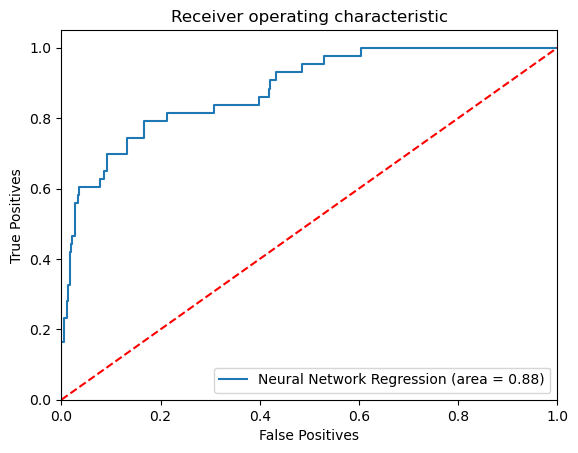

In [125]:
y_true_binary = np.zeros_like(y_test)
y_true_binary[y_test != 0] = 1
fpr, tpr, thresholds = roc_curve(y_true_binary, estimator.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Neural Network Regression (area = %0.2f)' % nn_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positives')
plt.ylabel('True Positives')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [126]:
test_xdata = load_data("test_x.csv")
new_df2 = clean_data(test_xdata, True)
new_df2 = new_df2.drop('nursingchartvalue', axis=1)
new_df2 = new_df2.drop('nursingchartcelltypevalname', axis=1)
new_df2 = new_df2.drop('offset', axis=1)
new_df2 = new_df2.drop('labname', axis=1)
new_df2 = new_df2.drop('labresult', axis=1)
new_df2 = new_df2.drop('Max pH', axis=1)
new_df2 = new_df2.drop('Min pH', axis=1)
print(new_df2.head(1))

y_pred2 = estimator.predict_proba(new_df2)[:,1]

           age  admissionweight  gender  Max Heart Rate  Min Heart Rate  \
151179.0  59.0              0.0     1.0           180.0            74.0   

          First Heart Rate  Last Heart Rate  Max Respiratory Rate  \
151179.0             112.0             97.0                  52.0   

          Min Respiratory Rate  First Respiratory Rate  ...  \
151179.0                  11.0                    30.0  ...   

          Max O2 Saturation  Min O2 Saturation  First O2 Saturation  \
151179.0               99.0               84.0                 87.0   

          Last O2 Saturation  First pH  Last pH  Max glucose  Min glucose  \
151179.0                93.0      7.23     7.23         7.23         7.23   

          First glucose  Last glucose  
151179.0           7.23          7.23  

[1 rows x 33 columns]


/Users/lamnguyen/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [127]:
def save_to_csv(prediction_probs, y):
    f = open("foo.csv", "w")
    f.write("patientunitstayid,hospitaldischargestatus" + "\n")

    for i,j in zip(y.index.values, prediction_probs):
        f.write(str(int(i)) + "," + str(j) + "\n")
    f.close()

In [128]:
save_to_csv(y_pred2, new_df2)